## 模拟生成低保真数据



### 首先是PBA储存模量LF

In [1]:
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from scipy.optimize import curve_fit
import itertools
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm
%config InlineBackend.figure_format = 'svg'
# 检查系统是否安装了 Arial 字体
def is_arial_available():
    for font in fm.fontManager.ttflist:
        if 'Arial' in font.name:
            return True
    return False

# 如果系统没有 Arial 字体，加载用户自定义字体
if not is_arial_available():
    user_font_path = os.path.expanduser('~/.local/share/fonts/ARIAL.TTF')
    if os.path.exists(user_font_path):
        # 添加用户字体到 Matplotlib 的字体管理器
        fm.fontManager.addfont(user_font_path)
        # 设置 Matplotlib 使用该字体
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
        print("已加载用户自定义 Arial 字体")
    else:
        print("未找到用户自定义 Arial 字体文件")
else:
    print("系统已安装 Arial 字体")
    


系统已安装 Arial 字体


Maxwell流体的频率-储存模量公式推导

Maxwell流体由一个弹簧和一个阻尼器串联组成。其本构方程为:

$\frac{1}{G}\frac{d\sigma}{dt} + \frac{\sigma}{\eta} = \frac{d\gamma}{dt}$

其中:
$\sigma$ - 应力
$\gamma$ - 应变 
$G$ - 弹性模量
$\eta$ - 粘度

在正弦振动下:
$\gamma = \gamma_0 \sin(\omega t)$
$\sigma = \sigma_0 \sin(\omega t + \delta)$

将上述表达式代入本构方程并化简,可得储存模量$G'(\omega)$:

$G'(\omega) = \frac{G\omega^2\lambda^2}{1 + \omega^2\lambda^2}$

其中$\omega$为角频率,$\lambda = \eta/G$为松弛时间


DP=40 拟合参数: G=1.10e+05, λ=8.38e-06
DP=162 拟合参数: G=4.48e+05, λ=3.43e-05
DP=274 拟合参数: G=5.93e+05, λ=6.25e-05
DP=454 拟合参数: G=5.66e+05, λ=8.95e-05
DP=611 拟合参数: G=3.45e+05, λ=1.17e-04
DP=798 拟合参数: G=6.26e+05, λ=1.04e-04
DP=1014 拟合参数: G=6.83e+05, λ=1.01e-04
DP=1184 拟合参数: G=1.14e+06, λ=5.20e-05
DP=1524 拟合参数: G=4.50e+05, λ=8.64e-04


/tmp/ipykernel_7805/187806344.py:78: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 2e7)


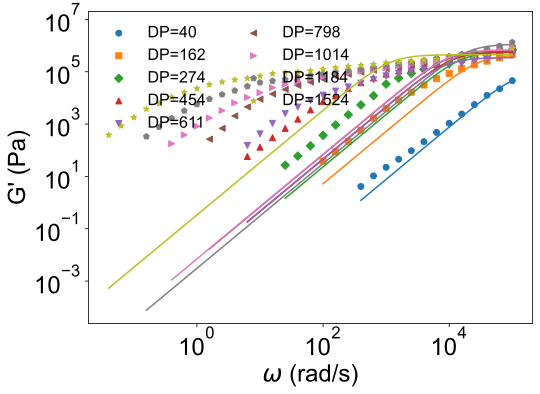

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 魔法命令，默认生成 SVG 格式的图像
%config InlineBackend.figure_format = 'svg'
plt.rcParams['font.family'] = ['Arial']  # 设置字体为 Arial
plt.rcParams['font.size'] = 24  # 设置全局字体大小

# 定义Maxwell模型的储能模量方程
def maxwell_storage_modulus(omega, G, lambda_):
    return G * omega**2 * lambda_**2 / (1 + omega**2 * lambda_**2)

# 读取实验数据
url_hf = 'Data/Data_HF.xlsx'  # Excel 文件路径
df_HF = pd.read_excel(url_hf, sheet_name=None)
df_hf_sm = df_HF['Sheet1']  # 提取第一个工作表的数据

# 按照 'DP' 列进行分组
grouped = df_hf_sm.groupby('DP')

# 初始化一个字典来存储拟合结果
fit_params = {}

# 创建图形和轴对象
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

# 定义颜色和标记样式
colors = plt.cm.tab10.colors  # 使用 tab10 颜色映射
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']  # 定义不同的标记样式

# 对每一组数据进行拟合
for i, (dp, group) in enumerate(grouped):
    # 提取实验数据
    omega = group['AngFreq'].values
    G = group['StorageM'].values
    
    try:
        # 使用curve_fit进行非线性拟合
        # 设置初始参数猜测值 [G, lambda]
        p0 = [max(G), 1/np.mean(omega)]
        # 设置参数边界
        bounds = ([0, 0], [np.inf, np.inf])
        
        popt, _ = curve_fit(maxwell_storage_modulus, omega, G, p0=p0, bounds=bounds)
        fit_params[dp] = popt
        
        # 生成拟合曲线的点
        omega_fit = np.logspace(np.log10(min(omega)), np.log10(max(omega)), 100)
        G_fit = maxwell_storage_modulus(omega_fit, *popt)
        
        # 绘制拟合曲线
        ax.plot(omega_fit, G_fit, color=colors[i % len(colors)])
        
        # 绘制实验数据点
        ax.scatter(omega, G, color=colors[i % len(colors)],
                  marker=markers[i % len(markers)], label=f'DP={dp}')
        
        print(f"DP={dp} 拟合参数: G={popt[0]:.2e}, λ={popt[1]:.2e}")
        
    except Exception as e:
        print(f"DP={dp} 拟合失败: {str(e)}")

# 设置图形属性
ax.set_xscale('log')  # 设置 x 轴为对数刻度
ax.set_yscale('log')  # 设置 y 轴为对数刻度

# 设置横纵坐标标签
ax.set_xlabel('$\omega$ (rad/s)')  # 设置 x 轴标签
ax.set_ylabel('G\' (Pa)')  # 设置 y 轴标签

# 添加图例，分两列显示
legend = ax.legend(ncol=2, fontsize=16, loc='upper left', frameon=False)
for line in legend.get_lines():
    line.set_linewidth(2)  # 设置图例中线的宽度
    
ax.set_ylim(0, 2e7)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

- PFGs LF 

DP = 40 拟合成功
DP = 162 拟合成功
DP = 274 拟合成功
DP = 454 拟合成功
DP = 611 拟合成功
DP = 798 拟合成功
DP = 1014 拟合成功
DP = 1184 拟合成功
DP = 1524 拟合成功


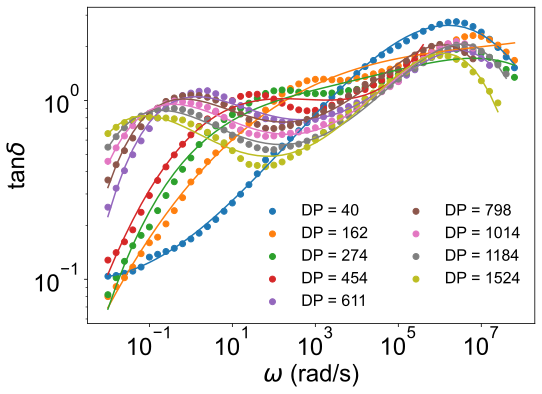

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# 魔法命令，默认生成 SVG 格式的图像
%config InlineBackend.figure_format = 'svg'
plt.rcParams['font.family'] = ['Arial']  # 设置字体为 Arial
plt.rcParams['font.size'] = 24  # 设置全局字体大小

# 读取实验数据
url_hf = 'Data_HF.xlsx'  # Excel 文件路径
df_HF = pd.read_excel(url_hf, sheet_name=None)
df_hf_sm = df_HF['Sheet2']  # 提取第一个工作表的数据

# 按照 'DP' 列进行分组
grouped = df_hf_sm.groupby('DP')

# 初始化一个字典来存储拟合结果
fit_results = {}

# 对每一组进行先对数化再多项式回归拟合
for name, group in grouped:
    # 提取 AngFreq 和 LossM 列的数据
    omega_experimental = group['AngFreq'].values.reshape(-1, 1)
    loss_experimental = group['LossFactor'].values

    # 对 omega 和 lossF 取对数
    log_omega = np.log(omega_experimental)
    log_loss = np.log(loss_experimental)

    # 使用多项式回归进行拟合（假设使用 3 次多项式）
    try:
        model = make_pipeline(PolynomialFeatures(degree=4), LinearRegression())
        model.fit(log_omega, log_loss)
        fit_results[name] = model
        print(f"DP = {name} 拟合成功")
    except Exception as e:
        print(f"DP = {name} 拟合失败，错误信息: {e}")
        fit_results[name] = None

# 创建图形和轴对象
fig, ax = plt.subplots(figsize=(8, 6),dpi=600)

# 对每一组生成预测曲线并绘图
for dp, model in fit_results.items():
    if model is None:
        continue  # 跳过拟合失败的组

    # 获取当前组的 AngFreq 数据
    group = grouped.get_group(dp)
    omega_virtual = group['AngFreq'].values.reshape(-1, 1)

    # 对 omega_virtual 取对数
    log_omega_virtual = np.log(omega_virtual)

    # 使用多项式回归模型预测
    log_loss_virtual = model.predict(log_omega_virtual)

    # 对预测结果取指数，还原为原始尺度
    loss_virtual = np.exp(log_loss_virtual)

    # 绘制预测曲线
    ax.plot(omega_virtual, loss_virtual)

    # 绘制原始数据点
    ax.scatter(group['AngFreq'], group['LossFactor'], label=f'DP = {dp}')

# 设置图形属性
ax.set_xscale('log')
ax.set_yscale('log')

# 设置横纵坐标标签
ax.set_xlabel('$\omega$ (rad/s)')  # 设置 x 轴标签
ax.set_ylabel('tan$\delta$')  # 设置 y 轴标签

# 添加图例，分三行显示
legend = ax.legend(ncol=2, fontsize=16, loc='lower right', frameon=False)
for line in legend.get_lines():
    line.set_linewidth(2)  # 设置图例中线的宽度

# 调整布局
plt.tight_layout()
# 显示图形
plt.savefig('LF_lossF.pdf', format='pdf')
plt.show()


- PFGs com

DP = b1 拟合成功
DP = b2 拟合成功
DP = b3 拟合成功
DP = b4 拟合成功
DP = b6 拟合成功
DP = b7 拟合成功


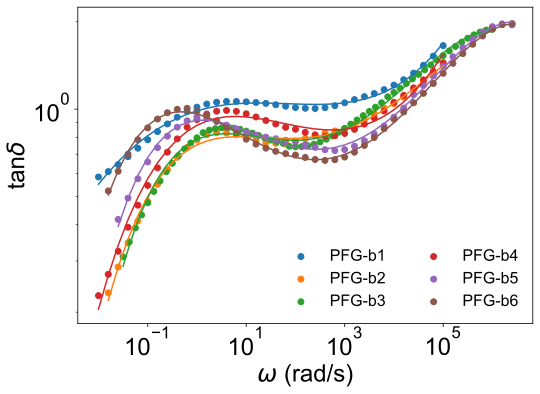

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# 魔法命令，默认生成 SVG 格式的图像
%config InlineBackend.figure_format = 'svg'
plt.rcParams['font.family'] = ['Arial']  # 设置字体为 Arial
plt.rcParams['font.size'] = 24  # 设置全局字体大小

# 读取实验数据
url_hf = 'Data/DifferComponent_data.xlsm'  # Excel 文件路径
df_HF = pd.read_excel(url_hf, sheet_name=None)
filtered_sheets = {name: df for name, df in df_HF.items() if name.lower() != 's'}  # 过滤工作表

# 合并所有工作表并添加标识列
combined_df = pd.concat(
    [df.assign(sheet_name=name) for name, df in filtered_sheets.items()],
    ignore_index=True
)

# 按工作表名称分组
grouped = combined_df.groupby('sheet_name')

# 初始化一个字典来存储拟合结果
fit_results = {}

# 对每一组进行先对数化再多项式回归拟合
for name, group in grouped:
    # 提取 AngFreq 和 LossM 列的数据
    omega_experimental = group['AngFreq'].values.reshape(-1, 1)
    loss_experimental = group['lossF'].values

    # 对 omega 和 lossF 取对数
    log_omega = np.log(omega_experimental)
    log_loss = np.log(loss_experimental)

    # 使用多项式回归进行拟合（假设使用 3 次多项式）
    try:
        model = make_pipeline(PolynomialFeatures(degree=4), LinearRegression())
        model.fit(log_omega, log_loss)
        fit_results[name] = model
        print(f"DP = {name} 拟合成功")
    except Exception as e:
        print(f"DP = {name} 拟合失败，错误信息: {e}")
        fit_results[name] = None

# 创建图形和轴对象
fig, ax = plt.subplots(figsize=(8, 6),dpi=600)

# 对每一组生成预测曲线并绘图
idx=0
for sheet_name, model in fit_results.items():
    if model is None:
        continue  # 跳过拟合失败的组
    idx+=1
    # 获取当前组的 AngFreq 数据
    group = grouped.get_group(sheet_name)
    omega_virtual = group['AngFreq'].values.reshape(-1, 1)

    # 对 omega_virtual 取对数
    log_omega_virtual = np.log(omega_virtual)

    # 使用多项式回归模型预测
    log_loss_virtual = model.predict(log_omega_virtual)

    # 对预测结果取指数，还原为原始尺度
    loss_virtual = np.exp(log_loss_virtual)

    # 绘制预测曲线
    ax.plot(omega_virtual, loss_virtual)

    # 绘制原始数据点
    ax.scatter(group['AngFreq'], group['lossF'], label=f'PFG-b{idx}')

# 设置图形属性
ax.set_xscale('log')
ax.set_yscale('log')

# 设置横纵坐标标签
ax.set_xlabel('$\omega$ (rad/s)')  # 设置 x 轴标签
ax.set_ylabel('tan$\delta$')  # 设置 y 轴标签

# 添加图例，分三行显示
legend = ax.legend(ncol=2, fontsize=16, loc='lower right', frameon=False)
for line in legend.get_lines():
    line.set_linewidth(2)  # 设置图例中线的宽度

# 调整布局
plt.tight_layout()
# 显示图形
#plt.savefig('LF_lossF.pdf', format='pdf')
plt.show()
